# 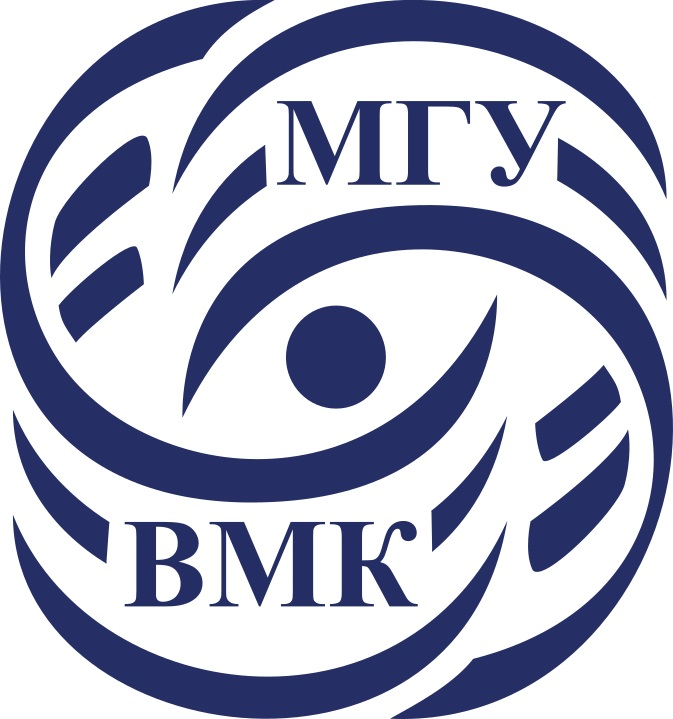

# Машинное обучение. ВМК МГУ

# Практическое задание 3: Линейные модели: регрессия

## Уровень: <font color='MediumSeaGreen'>**Исследовательский (Research)**</font>

# О формате сдачи

🔷 **<font color='plum'>При решении ноутбука используйте данный шаблон</font>**

    ✅ Можно добавлять новые ячейки любых типов
    ❌ Не нужно удалять текстовые ячейки c разметкой частей ноутбука и формулировками заданий


🔷 **<font color='plum'>При оценивании задач учитывается код</font>**

    ✅ Задания, в которых необходим код, обычно помечаются фразами "Your code here"/"Ваш код" и аналогичными
    ❌ Ответы на вопросы без сопутствующего кода оцениваются в 0 баллов
    ❌ Наличе работоспособного кода в ноутбуке, если на сказано иного, обязательно

🔷 **<font color='plum'>При оценивании задач учитываются выводы</font>**

    ✅ Задания, в которых необходимы выводы, обычно помечаются фразами Вывод"/"Ответ на вопрос"/"Ваш текст" и аналогичными
    ✅ Обычно выводы подразумевают под собой текстовый ответ (можно писать markdown, latex).
    ✅ Сопутствующие изображения, графики, таблички - приветствуются!
    ❌ При отсутствии выводов задание не засчитается на полный балл

-----------
<font color="white" style="opacity:0.2024"></font>







Цель данного задания:

* Узнать, что такое переобучение и как с ним бороться в линейных моделях;
* Понять, чем отличаются разные регуляризаторы;
* Научиться решать задачу регрессии линейными моделями.
-------
<font color=DarkOrange>**Примерное время выполнения (execution time/время выполнения, если нажать run all) всех ячеек ноутбука при правильной реализации: 7 минут </font>**

# Подготовка рабочей среды

Сначала установим нужные нам версии библиотек. Мы гарантируем, что в данных версиях задание будет корректно отрабатывать.

После установки нужных версий, **возможно,** нужно перезагрузить среду (runtime), но скорее всего вам это не понадобится


На скачивание файла и установку понадобится не более 5 минут.

<font color='OrangeRed'>**Важно!**</font>

Устанавливать нужные версии нужно каждый раз, когда создается новый рантайм. Например, если вы 2 часа подряд делаете это задание, то подготовить библиотеки достаточно 1 раз. Но если вы, например, начали в понедельник, затем закрыли/выключили ноутбук, то при продолжении в среду, вам нужно будет запустить рантайм заново и следовательно заново установить библиотеки.

<font color='OrangeRed'>**Важно!**</font>
Если вы предпочитаете делать практические задания на своем личном ноутбуке, то проверьте, что вы установили рабочее окружение в [соответствии с гайдом](https://github.com/MSU-ML-COURSE/ML-COURSE-24-25/blob/main/tutorials/%D0%A2%D1%83%D1%82%D0%BE%D1%80%D0%B8%D0%B0%D0%BB%20%D0%BF%D0%BE%20%D1%83%D1%81%D1%82%D0%B0%D0%BD%D0%BE%D0%B2%D0%BA%D0%B5%20%D1%80%D0%B0%D0%B1%D0%BE%D1%87%D0%B5%D0%B3%D0%BE%20%D0%BE%D0%BA%D1%80%D1%83%D0%B6%D0%B5%D0%BD%D0%B8%D1%8F%20%D0%B2%20Python%20%D0%B4%D0%BB%D1%8F%20%D1%80%D0%B5%D1%88%D0%B5%D0%BD%D0%B8%D1%8F%20%D0%B7%D0%B0%D0%B4%D0%B0%D1%87%20(2).pdf)


In [31]:
# !!! Данный блок будет работать только в Google-Colab !!!
! gdown 10k8Hwn9kpK9SpK4IEj4-EaWQZqgYT5-Q
! pip install -r /content/requirements_2024_25_for_colab_small.txt

Downloading...
From: https://drive.google.com/uc?id=10k8Hwn9kpK9SpK4IEj4-EaWQZqgYT5-Q
To: /content/requirements_2024_25_for_colab_small.txt
100% 375/375 [00:00<00:00, 974kB/s]


Проверим версию библиотеки:

In [32]:
import catboost
assert(catboost.__version__ == '1.2.7')

Теперь можно приступать к выполнению задания! :)

-----------
<font color="white" style="opacity:0.2024"></font>

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter("ignore")
sns.set(style="darkgrid")
%matplotlib inline

## Линейная регрессия и регуляризация

Напомним, что линейная регрессия — это модель следующего вида: $$a(x) = \langle w, x \rangle + b$$ где $w \in \mathbb{R}^d$, $b \in \mathbb{R}$. Обучить линейную регрессию — значит найти $w$ и $b$.

В модели линейной регрессии с $l_2$ регуляризацией мы оптимизируем следующий функционал:

$\frac{1}{N} \cdot ∑_{i=1}^M (w_1 \cdot x_{i1} + \dots w_n \cdot x_{in} + b - y_i)^2 + \frac{\alpha}{2} \cdot \left( w_1^2 + \dots + w_n^2 \right) \rightarrow \min_{w_1, \dots, w_n, b}$

В модели линейной регрессии с $l_1$ регуляризацией мы оптимизируем следующий функционал:

$\frac{1}{N} \cdot ∑_{i=1}^M (w_1 \cdot x_{i1} + \dots w_n \cdot x_{in} + b - y_i)^2 + \alpha \cdot \left( |w_1| + \dots + |w_n| \right) \rightarrow \min_{w_1, \dots, w_n, b}$

### <font color='DarkOrange'>**Задание 1 [1 балл]**</font>

Почему при обучении линейных моделей, коэффициент $b$ не регуляризуется? Дайте ответ с опорой на лекции. Возможно вам также поможет картика из базовой части

<font color='MediumOrchid'>**Ваши выводы тут:**</font>

Функция потерь с регуляризацией:
$$L_{\text{reg}}(w, b) = L(w, b) + \lambda R(w)$$
Регуляризация включает в себя добавление штрафа к функции потерь, который зависит от весов $w$ и не зависит от смещения $b$.

Поскольку регуляризационный член $R(w)$ не зависит от $b$, его производная по $b$ будет равна нулю:
$$\frac{\partial R(w)}{\partial b} = 0$$

При обновлении весов модели в процессе обучения смещение не будет изменяться из-за добавления регуляризационного члена к функции потерь:
$$b' = b - \eta \frac{\partial L_{\text{reg}}(w, b)}{\partial b} = = b - \eta \frac{\partial L(w, b)}{\partial b}$$

-----
<font color="white" style="opacity:0.2023"></font>

Рассмотрим модель линейной регрессии с $l_2$ регуляризацией. В sklearn эта модель реализована посредством класса Ridge. В нём есть методы fit и predict. Первый принимает на вход обучающую выборку и вектор целевых переменных и обучает модель, второй, будучи вызванным после обучения модели, возвращает предсказание на выборке.

Сгенерируем случайные данные. Пусть $x$ будет обычным числом из равномерного распределения, а $𝑦=0.5 \cdot x + 0.1$ &mdash; целевая переменная. При этом наблюдаем мы $\overline{y} = y + \varepsilon,~\varepsilon \sim N(0, 0.01)$. Добавим в данные к переменной $x$ её же умноженную на $3$. То есть, теперь у нас два признака $x_1$ и $x_2 = 3 \cdot x_1$.

Поскольку  $y = c \cdot 0.5 \cdot x_1 + \frac{1 - c}{6} \cdot x_2 + 0.1$, где $c$ любое сколь угодно большое вещественное число. То, как мы могли убедиться в базовой части, без регуляризации есть риск выучить очень большие веса.

Посмотрим, как меняется значения весов, в зависимости от значения коэффициента регуляризации.

In [34]:
from sklearn.linear_model import Ridge

In [35]:
np.random.seed(1)
X = np.random.uniform(0, 1, 100)
Y = X * 0.5 + 0.1 + np.random.randn(100) * 0.1

X3 = np.hstack((X[:, None], 3 * X[:, None]))
Y3 = X3[:, 0] * 0.5 + 0.1 + np.random.randn(100) * 0.1

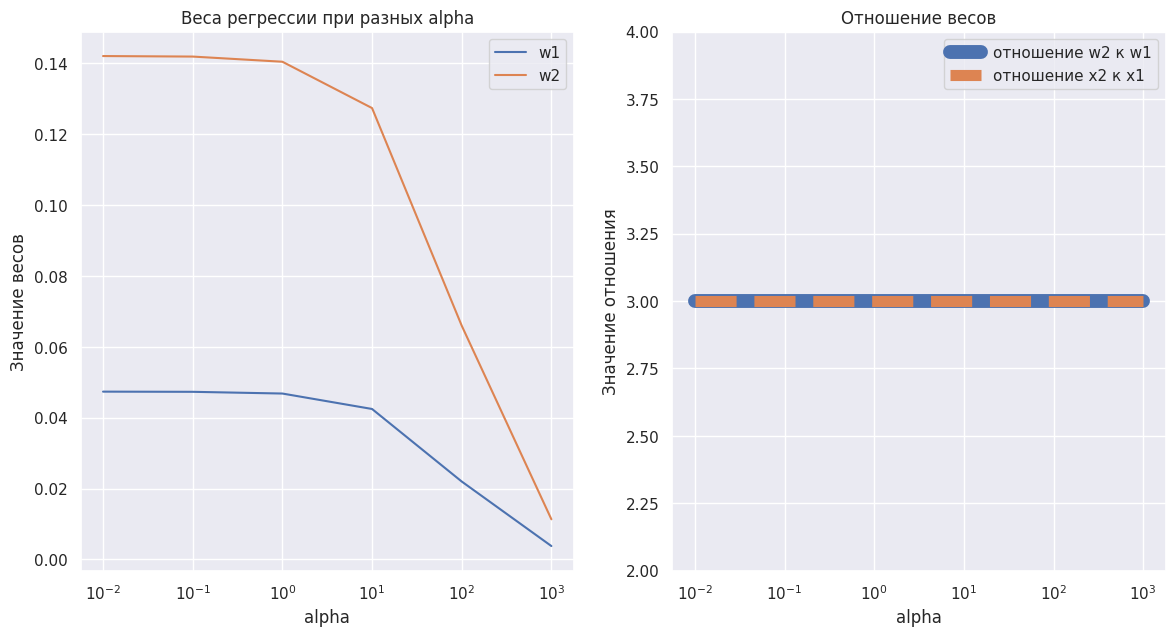

In [36]:
w1 = []
w2 = []

alphas = [0.01, 0.1, 1, 10, 100, 1000]

for alpha in alphas:
    reg = Ridge(alpha=alpha)
    reg.fit(X3, Y3)
    w1.append(reg.coef_[0])
    w2.append(reg.coef_[1])

w1 = np.array(w1)
w2 = np.array(w2)

fig, axs = plt.subplots(figsize=(14, 7), ncols=2)
axs[0].plot(alphas, w1, label="w1")
axs[0].plot(alphas, w2, label="w2")
axs[0].set_xscale("log")
axs[0].set_title("Веса регрессии при разных alpha")
axs[0].set_xlabel("alpha")
axs[0].set_ylabel("Значение весов")
axs[0].legend()
axs[1].plot(alphas, w2 / w1, label="отношение w2 к w1", linewidth=10)
axs[1].plot([0.01, 1000], [3, 3], label="отношение x2 к x1", linestyle="--", linewidth=8)
axs[1].set_xscale("log")
axs[1].set_ylim(2,4)
axs[1].set_xlabel("alpha")
axs[1].set_ylabel("Значение отношения")
axs[1].set_title("Отношение весов")
axs[1].legend()
plt.show()

### <font color='DarkOrange'>**Задание 2 [2 баллa]**</font>

Как думаете, почему отношение между весами постоянно? (подсказка, необходимо выписать функцию потерь и посчитать производные по весам)

<font color='MediumOrchid'>**Ваши выводы тут:**</font>

$$x_{i2} = kx_{i1}$$

Функция потерь для линейной регрессии с L2 регуляризацией может быть записана следующим образом:

$$L(w) = \sum_{i=1}^{n} \left( x_{i1} w_1 + x_{i2} w_2 + b - y_i \right)^2 + \alpha (w_1^2 + w_2^2) = \sum_{i=1}^{n} \left( x_{i1} w_1 + kx_{i1} w_2 + b - y_i \right)^2 + \alpha (w_1^2 + w_2^2)$$

Для нахождения оптимальных весов нам необходимо взять производные функции потерь по весам $w_1$ и $w_2$ и приравнять их к $0$:

$$
\frac{\partial L}{\partial w_1} = 2 \sum_{i=1}^{n} (x_{i1} w_1 + kx_{i1} w_2 + b - y_i)x_{i1} + 2\alpha w_1 = 0
$$

$$
\frac{\partial L}{\partial w_2} = 2k \sum_{i=1}^{n} (x_{i1} w_1 + kx_{i1} w_2 + b - y_i)x_{i1} + 2\alpha w_2 = 0
$$

Пусть:
$$
\gamma = \sum_{i=1}^{n} (x_{i1} w_1 + kx_{i1} w_2 + b - y_i)x_{i1}
$$

Тогда:
$$
\gamma + \alpha w_1 = 0, \quad k\gamma + \alpha w_2 = 0
$$

Отсюда находим:
$$
w_1 = -\frac{\gamma}{\alpha}, \quad w_2 = -\frac{k\gamma}{\alpha}
$$

Итого:
$$
\frac{w_2}{w_1} = \frac{k \cdot \gamma \cdot \alpha}{\gamma \cdot \alpha} = k
$$


-----
<font color="white" style="opacity:0.2023"></font>

Заметим, что при $l_2$ регуляризации в данном примере веса получились пропорциональны значениям признаков. При этом, мы знаем, что оба признака взаимно однозначны, и прогноз можно делать только по одному из них. Для этого придумана $l_1$ регуляризация. В билиотеке sklearn линейная регрессия с $l_1$ регуляризацией реализована в классе Lasso

### <font color='DarkOrange'>**Задание 3 [2 баллa]**</font>

Почему в нашем примере $l_1$ регуляризация приведёт к разреживанию весов? (подсказка, нужно опять подсчитать производную, но обратите внимание на дифференцируемость модуля).

<font color='MediumOrchid'>**Ваши выводы тут:**</font>

Функция потерь с L1 регуляризацией:
$$
L(w) = \sum_{i=1}^{n} \left( \sum_{j=1}^{m} x_{ij} w_j + b - y_i \right)^2 + \alpha \sum_{j=1}^{m} |w_j|
$$

Для нахождения оптимальных весов нам необходимо взять производные функции потерь по весам:
$$
\frac{\partial L}{\partial w_j} = 2 \sum_{i=1}^{n} \left( \sum_{j=1}^{m} x_{ij} w_j + b - y_i \right) x_{ij} + \alpha \, \text{sgn}(w_j) = 0
$$

Производная функции потерь терприт разрыв там, где $w_j = 0$. Это связано с тем, что производная члена L1-регуляризации (модуля) не является гладкой в этой точке.

Когда $w_j$ близко к нулю, влияние члена $\alpha \, \text{sgn}(w_j)$ становится значительным.

При этом член $$2 \sum_{i=1}^{n} \left( \sum_{j=1}^{m} x_{ij} w_j + b - y_i \right) x_{ij}$$
может быть недостаточно большим по модулю, чтобы компенсировать штраф за L1-регуляризацию. Это приводит к тому, что некоторые веса начинают стремиться к нулю.

-----

Добавим $l_1$ регуляризацию и посмотрим, как меняется значения весов, в зависимости от значения коэффициента регуляризации.

In [37]:
from sklearn.linear_model import Lasso

In [38]:
reg = Lasso(alpha=1., max_iter=1000, tol=1e-4)
reg.fit(X3, Y3)
print("Веса, при alpha = 1.")
print("w1:", reg.coef_[0], "\tw2:", reg.coef_[1])
print()

reg = Lasso(alpha=0.1, max_iter=1000, tol=1e-4)
reg.fit(X3, Y3)
print("Веса, при alpha = 0.1")
print("w1:", reg.coef_[0], "\tw2:", reg.coef_[1])
print()

reg = Lasso(alpha=0.01, max_iter=1000, tol=1e-4)
reg.fit(X3, Y3)
print("Веса, при alpha = 0.01")
print("w1:", reg.coef_[0], "\tw2:", reg.coef_[1])
print()

reg = Lasso(alpha=0.001, max_iter=1000, tol=1e-4)
reg.fit(X3, Y3)
print("Веса, при alpha = 0.001")
print("w1:", reg.coef_[0], "\tw2:", reg.coef_[1])
print()

reg = Lasso(alpha=0.0001, max_iter=1000, tol=1e-4)
reg.fit(X3, Y3)
print("Веса, при alpha = 0.0001")
print("w1:", reg.coef_[0], "\tw2:", reg.coef_[1])
print()

reg = Lasso(alpha=0.00001, max_iter=1000, tol=1e-4)
reg.fit(X3, Y3)
print("Веса, при alpha = 0.00001")
print("w1:", reg.coef_[0], "\tw2:", reg.coef_[1])
print()

Веса, при alpha = 1.
w1: 0.0 	w2: 0.0

Веса, при alpha = 0.1
w1: 0.0 	w2: 0.029684463509327023

Веса, при alpha = 0.01
w1: 0.0 	w2: 0.14506160917248503

Веса, при alpha = 0.001
w1: 0.0 	w2: 0.1565993237388008

Веса, при alpha = 0.0001
w1: 0.0 	w2: 0.1577530951954324

Веса, при alpha = 0.00001
w1: 0.3966873199145481 	w2: 0.025639365702912847



### <font color='DarkOrange'>**Задание 4 [2 баллa]**</font>

Почему в итоге при $\alpha = 0.00001$ получились веса не равные нулю?

<font color='LightSteelBlue'>**Подсказка**</font>

 Обратите внимание на то, каким странным получился вес $w_2$

<font color='MediumOrchid'>**Ваши выводы тут:**</font>

При низких значениях $\alpha$ штраф за большие веса оказывается незначительным, что позволяет весам быть ненулевыми. С увеличением $\alpha$ влияние регуляризации усиливается и накладывает все более значительный штраф на величину весов.

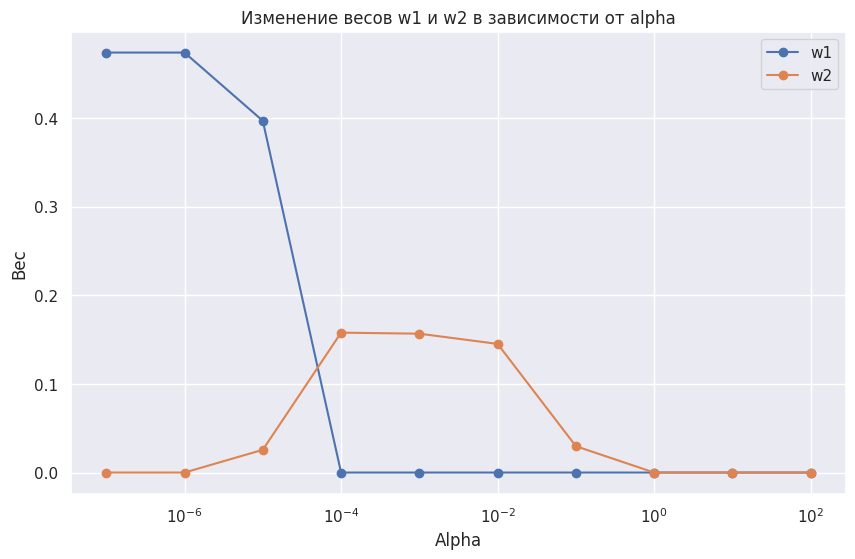

Alpha                w1         w2        
----------------------------------------
100.0000000000       0.0000     0.0000    
10.0000000000        0.0000     0.0000    
1.0000000000         0.0000     0.0000    
0.1000000000         0.0000     0.0297    
0.0100000000         0.0000     0.1451    
0.0010000000         0.0000     0.1566    
0.0001000000         0.0000     0.1578    
0.0000100000         0.3967     0.0256    
0.0000010000         0.4736     0.0000    
0.0000001000         0.4736     0.0000    


In [39]:
alphas = [100., 10., 1., 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001, 0.0000001]
weights = []

for alpha in alphas:
    reg = Lasso(alpha=alpha, max_iter=1000, tol=1e-4)
    reg.fit(X3, Y3)
    weights.append(reg.coef_)

weights = np.array(weights)

plt.figure(figsize=(10, 6))
plt.plot(alphas, weights[:, 0], marker='o', label='w1')
plt.plot(alphas, weights[:, 1], marker='o', label='w2')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Вес')
plt.title('Изменение весов w1 и w2 в зависимости от alpha')
plt.legend()
plt.grid(color='white', linestyle='-', linewidth=1)
plt.show()

print(f"{'Alpha':<20} {'w1':<10} {'w2':<10}")
print("-" * 40)
for i, alpha in enumerate(alphas):
    print(f"{alpha:<20.10f} {weights[i][0]:<10.4f} {weights[i][1]:<10.4f}")

**Высокие значения $\alpha$ ($\alpha > 0.1$)**

При этих значениях регуляризация очень сильная. Она накладывает значительный штраф на величину весов, что приводит к тому, что оба веса становятся равными нулю. Ибо ненулевые веса значительно увеличивают общую функцию потерь из-за сильного штрафа.

**Понижение $\alpha$ до 0.0001 и ниже**

При $\alpha = 0.1$ регуляризация все еще достаточно сильная, но уже не так критична. Вес $w_2$ начинает принимать ненулевое значение ($0.0297$), тогда как $w_1$ остается равным нулю.

Вес $w_2$ продолжает увеличиваться (до $0.1578$), а $w_1$ по-прежнему равен нулю. Это указывает на то, что модель считает $w_2$ более значимым для предсказания целевой переменной.

**Переход к очень малым значениям $\alpha$**

При $\alpha = 0.00001$ штраф становится незначительным: при таком уровне регуляризации штраф за ненужные веса становится достаточно малым, что позволяет весам быть ненулевыми.
Вес $w_1$ становится ненулевым ($0.3967$), при этом вес $w_2$ также остается ненулевым ($0.0256$).

**Уменьшение $\alpha$ до $0.000001$ и ниже**

При дальнейшем уменьшении $\alpha$ модель делает выбор в пользу $w_1$.

-----

В предущих блоках мы использовали модельные примеры, в которых $y$ зависел от $x$ линейно. Но так бывает далеко не всегда.

### <font color='DarkOrange'>**Задание 5 [1 баллa]**</font>

 Придумайте, сгенерируйте и визуализируйте пример, в котором линейная регрессия будет плохо классифицировать данные.

MSE loss: 1075.2465996400524


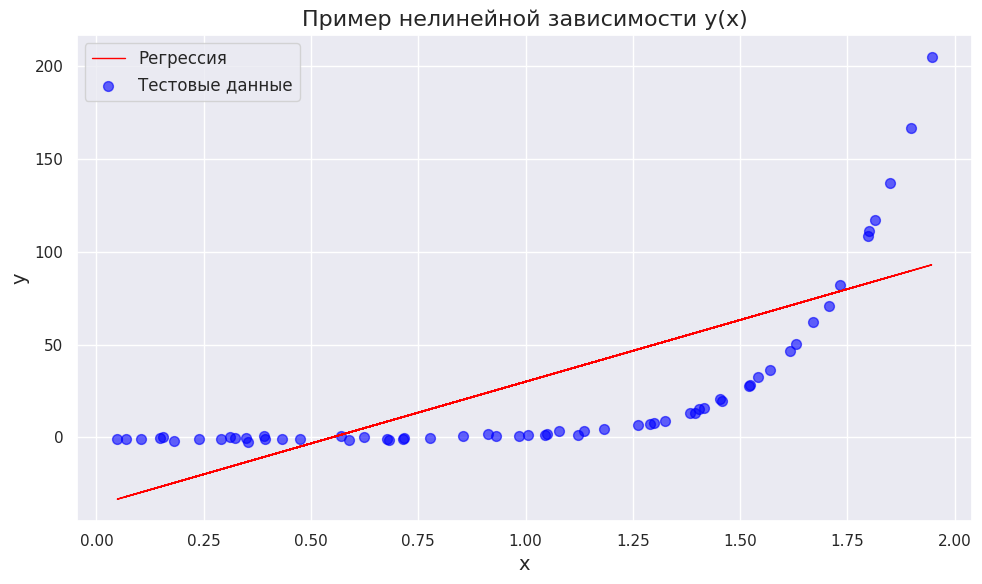

In [40]:
from sklearn.model_selection import train_test_split

np.random.seed(42)

X = np.random.uniform(0, 2, 300)[:, np.newaxis]
Y = X[:, 0]**8 + np.random.randn(300) # Y(X) = X^8 + ϵ

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

reg = Ridge(alpha=1.0)
reg.fit(X_train, Y_train)

Y_test_pred = reg.predict(X_test)

mse_loss = np.mean((Y_test_pred - Y_test) ** 2)
print("MSE loss:", mse_loss)

plt.figure(figsize=(10, 6))
plt.plot(X_test[:, 0], Y_test_pred, label='Регрессия', color='red', linewidth=1)
plt.scatter(X_test[:, 0], Y_test, label='Тестовые данные', color='blue', alpha=0.6, s=50)

plt.xlabel("x", fontsize=14)
plt.ylabel("y", fontsize=14)
plt.title('Пример нелинейной зависимости y(x)', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

### <font color='DarkOrange'>**Задание 6 [2 баллa]**</font>

Приведите искусственный пример (можно даже очень неправдоподобный), когда линейная регрессия с $l_2$ регуляризацией гарантированно занулит какой-нибудь признак? Покажите (теоретически или программно), что признак действительно зануляется


<font color='MediumOrchid'>**Ваши выводы тут:**</font>

Рассмотрим ситуацию, когда один из признаков принимает только нулевые значения. Обозначим этот признак как $x_{i1}$.

$$
\frac{\partial L}{\partial w_1} = 2\sum_{i=1}^{n} \left( x_{i1} w_1 + x_{i2} w_2 + b - y_i \right) x_{i1} + 2\alpha w_1 = 0
$$

$$
\frac{\partial L}{\partial w_1} = 0 + 2\alpha w_1 = 0
$$

$$
\Rightarrow w_1 = 0
$$

То есть если существует признак, который принимает только нулевые значения, то соответствующий ему вес также будет занулен.

In [42]:
x1 = np.zeros(100)
x2 = np.random.rand(100)
X = np.column_stack((x1, x2))
y = np.random.rand(100)

model = Ridge(alpha=1.0)
model.fit(X, y)
weights = model.coef_

print("Веса признаков:", weights)

Веса признаков: [0.         0.04076146]


**Выводы** В первой части задания по линейным моделям мы должны были узнать:
.

1.   Зачем нужна регуляризация.
2.   Как отбирать значащие признаки.
3.   Когда линейные модели работают хорошо, а когда плохо

-----
<font color="white" style="opacity:0.2023"></font>

Во **второй части** мы будем применять линейные модели для классификации реальных данных, где мы сможем проверить наши выводы, полученные на искуственных примерах. А также убедимся в полезности нормировки и научимся работать с разными видами данных.
